# CNN Implementation with PyTorch

Dataset: CIFAR10 (Ref: https://www.cs.toronto.edu/~kriz/cifar.html)
Info: <br>
> Number of Images: 60000,  32 * 32 in resolution
> Number of Classes: 10 (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck)

**Prerequisites**
> PyTorch Basics: https://youtu.be/OIenNRt2bjg
> Python Basics: https://youtu.be/rfscVS0vtbw

**References:**
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-Regularization-in-PyTorch--VmlldzoxNTgwOTE
3. https://medium.com/artificialis/dropout-regularization-using-pytorch-in-python-7765337cb158
3. https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
4. https://pytorch.org/vision/main/datasets.html
5. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
6. https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html#:~:text=Tensors%20are%20a%20specialized%20data,GPUs%20or%20other%20hardware%20accelerators.

## Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Necessary Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## Define transforms (Data Augmentation)

In [ ]:
# Define transforms

# For training set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# For testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Tensors**
> - Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.
> - Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.
> - Tensors are also optimized for automatic differentiation.


# Load datasets and define the

Torchvision provides many built-in datasets in the torchvision.datasets module, as well as utility classes for building your own datasets (https://pytorch.org/vision/main/datasets.html).

> PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
# Load datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 12911666.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# created dataloaders

batch_size = 25  # Define batch size

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

**Try!**
Here we have used only two sets are training and the testing tests. However, for the hyperparameter tuning we need the validation set as well. Therefore, find out a solution to split the test set into two and, redo the dataset loading and dataloader preparation.

In [ ]:
# Define the classes in the dataset

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Display a Sample of Images

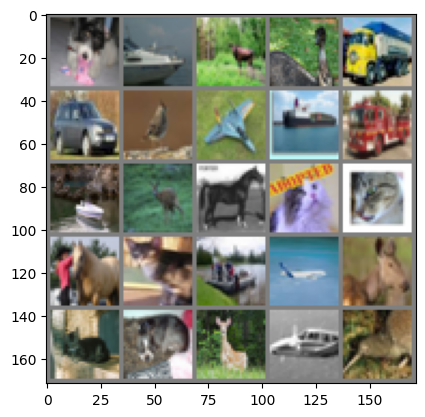

dog   ship  deer  bird  truck car   bird  plane ship  truck ship  deer  horse cat   cat   horse cat   ship  plane deer  cat   dog   deer  plane bird 


In [ ]:
# Visualize a batch of images

def imshow(img):
    img = img / 2 + 0.5;  # Unnormalized
    # Convert image into a Numpy Array for data manipuation and usage in
    # matplotlib
    npimg = img.numpy()
    # In numpy images defined as no. of channels, height, width format
    # However, matplotlib expects in height, width, channels format
    # So, we need to transform the npimg.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=5))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define CNN

In [ ]:
# Define the CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 0)  # In channels, out channels, kernel size, stride, padding
        self.bn1 = nn.BatchNorm2d(6)  # Number of features/channels
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride; we can also define padding, but in general not being used
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16 * 6 * 6, 144)
        self.bn3 = nn.BatchNorm1d(144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize a instance of the model

model = CNN()

## Define the Device

In [ ]:
# If cuda GPU is available, it will be set as the device otherwise cpu

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Transfer model to the device

model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=576, out_features=144, bias=True)
  (bn3): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=144, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=10, bias=True)
)

In [ ]:
# Generate summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 12, 12]             880
       BatchNorm2d-5           [-1, 16, 12, 12]              32
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Linear-7                  [-1, 144]          83,088
       BatchNorm1d-8                  [-1, 144]             288
           Dropout-9                  [-1, 144]               0
           Linear-10                   [-1, 72]          10,440
           Linear-11                   [-1, 10]             730
Total params: 95,926
Trainable params: 95,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## Define the Loss Function and Optimizer

In [ ]:
# Define loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train the model

In [ ]:
# Train the defined model

for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients

        # PyTorch, by default, accumulates gradients during the backward() pass of backpropagation.
        # This means that the calculated gradients from each mini-batch of data are added to any
        # existing gradients from earlier mini-batches.

        # To ensure that a parameter update during training reflects the gradients of the current batch of data (and not a mix of past data),
        # it's crucial to clear those old gradients before calculating the new ones.

        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Training Done")

[1,  2000] loss: 1.689
[2,  2000] loss: 1.392
[3,  2000] loss: 1.302
[4,  2000] loss: 1.242
[5,  2000] loss: 1.194
[6,  2000] loss: 1.161
[7,  2000] loss: 1.129
[8,  2000] loss: 1.102
[9,  2000] loss: 1.085
[10,  2000] loss: 1.061
[11,  2000] loss: 1.046
[12,  2000] loss: 1.032
[13,  2000] loss: 1.013
[14,  2000] loss: 0.997
[15,  2000] loss: 0.990
[16,  2000] loss: 0.980
[17,  2000] loss: 0.967
[18,  2000] loss: 0.956
[19,  2000] loss: 0.951
[20,  2000] loss: 0.942
[21,  2000] loss: 0.928
[22,  2000] loss: 0.924
[23,  2000] loss: 0.919
[24,  2000] loss: 0.906
[25,  2000] loss: 0.896
Training Done


## Model Saving and Loading

In [ ]:
# Saving

PATH = '/content/drive/MyDrive/AI/Model Weights/cifar_net_demo.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Loading

model = CNN() # Optional if you gave done that in one of the previous steps
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=576, out_features=144, bias=True)
  (bn3): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=144, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=10, bias=True)
)

## Performance with Testset

In [ ]:
# Measure performance of the test set

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest output value is what we choose as prediction
        # torch.max returns two values as (max, max_indices)
        # here we are only interested about the indices not the max value.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 63 %


**Try!**
In the above cases, we did not utilized any validation set and no hyperparameter tuning has been performed either. So model performance should be able to improve by performing some hyperparameter tuning.

**Try!**
Furthermore, try to measure the training and validation set losses/accuracies within the training loop and plot them in a single plot. In this way, we will be able to identify whether model is overfitting or not. In the above case, neither training or validation losses/accuracies were calculated. Try to record the performance once per certain number of batches.

**Try!**
Try to integrate early stopping into the training loop when the model performance w.r.t the validation set is no longer improving with further training. Try to think of a possible logic and add that into the training loop accordingly.

## Performance for Different Classes

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count) / total_pred[classname]
    print(f"Accurqacy for class {classname:5s} is {accuracy:.1f}%")

Accurqacy for class plane is 71.3%
Accurqacy for class car   is 75.0%
Accurqacy for class bird  is 45.2%
Accurqacy for class cat   is 39.7%
Accurqacy for class deer  is 60.1%
Accurqacy for class dog   is 55.6%
Accurqacy for class frog  is 75.8%
Accurqacy for class horse is 72.0%
Accurqacy for class ship  is 75.9%
Accurqacy for class truck is 71.6%
